# Exploration des Données

## Contexte du projet

### Dataset : Capital Bikeshare System (Washington D.C.)
- **Période** : 2011-2012 (2 ans de données)
- **Source** : Capital Bikeshare, Washington D.C., USA
- **Système** : Locations automatiques de vélos en libre-service
- **Données météo** : Freemeteo.com
- **Records** : 731 jours (données journalières)

### Objectif 
Prédire le nombre de locations de vélos par jour en fonction des conditions environnementales et saisonnières.


## Structure du notebook
1. **Importation des bibliothèques**
2. **Chargement et première exploration des données**
3. **Analyse de la qualité des données**
4. **Classification rigoureuse des variables**
5. **Exploration des variables catégorielles**
6. **Exploration des variables numériques**
7. **Visualisations exploratoires**
   - 7.1 **Correlation temporel**
   - 7.2 **Correlation météo**
8. **Conclusion**


## 1. Importation des bibliothèques

Nous commençons par importer toutes les bibliothèques nécessaires pour l'analyse des données et la visualisation.


In [70]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration des graphiques pour de meilleures visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppression des warnings pour une sortie plus propre
import warnings
warnings.filterwarnings('ignore')

print("Toutes les bibliothèques ont été importées")


Toutes les bibliothèques ont été importées


## 2. Chargement des données

Nous chargeons les deux fichiers de données disponibles :
- `day.csv` : données agrégées par jour
- `hour.csv` : données détaillées par heure

Pour cette exploration, nous nous concentrons sur les données journalières qui sont plus appropriées pour une analyse globale.


In [71]:

# Données journalières (notre focus principal)
df_day_initial = pd.read_csv('data/day.csv')

# Données horaires (pour référence)
df_hour_initial = pd.read_csv('data/hour.csv')

print(f"Données journalières chargées : {df_day_initial.shape[0]} lignes, {df_day_initial.shape[1]} colonnes")
print(f"Données horaires chargées : {df_hour_initial.shape[0]} lignes, {df_hour_initial.shape[1]} colonnes")


Données journalières chargées : 731 lignes, 16 colonnes
Données horaires chargées : 17379 lignes, 17 colonnes


## 3. Première exploration des données

Commençons par examiner la structure de nos données pour comprendre ce que nous avons.


In [72]:
# Informations générales sur le dataset
print(f"Dimensions du dataset : {df_day_initial.shape[0]} lignes × {df_day_initial.shape[1]} colonnes")
print(f"Période couverte : {df_day_initial['dteday'].min()} à {df_day_initial['dteday'].max()}")
print(f"Nombre de jours : {df_day_initial.shape[0]} jours")

print("\n Colonne disponible :")
for i, col in enumerate(df_day_initial.columns, 1):
    print(f"{i:2d}. {col}")


Dimensions du dataset : 731 lignes × 16 colonnes
Période couverte : 2011-01-01 à 2012-12-31
Nombre de jours : 731 jours

 Colonne disponible :
 1. instant
 2. dteday
 3. season
 4. yr
 5. mnth
 6. holiday
 7. weekday
 8. workingday
 9. weathersit
10. temp
11. atemp
12. hum
13. windspeed
14. casual
15. registered
16. cnt


### Description des variables

D'après l'aperçu et la documentation, voici ce que représentent les principales colonnes :

**Variables temporelles :**
- `instant` : Index d'enregistrement
- `dteday` : Date
- `season` : Saison (1=printemps, 2=été, 3=automne, 4=hiver)
- `yr` : Année (0=2011, 1=2012)
- `mnth` : Mois (1 à 12)
- `weekday` : Jour de la semaine (0=dimanche, 6=samedi)
- `holiday` : Jour férié (extrait du calendrier officiel de Washington D.C.)
- `workingday` : Jour ouvrable (ni weekend ni jour férié)

**Variables météorologiques (normalisées) :**
- `weathersit` : Conditions météo
  - 1: Clair, peu de nuages, partiellement nuageux
  - 2: Brouillard + nuageux, brouillard + nuages épars
  - 3: Légère neige, pluie légère + orage + nuages épars
  - 4: Pluie forte + grêle + orage + brouillard, neige + brouillard
- `temp` : Température normalisée (°C divisée par 41)
- `atemp` : Température ressentie normalisée (°C divisée par 50)
- `hum` : Humidité normalisée (divisée par 100)
- `windspeed` : Vitesse du vent normalisée (divisée par 67)

**Variables de location :**
- `casual` : Utilisateurs occasionnels (non-membres)
- `registered` : Utilisateurs enregistrés (membres)
- `cnt` : Total des locations (casual + registered)

**Note importante :** Les données météorologiques sont normalisées, ce qui explique pourquoi les valeurs sont entre 0 et 1.


## 4. Analyse de la qualité des données

Vérifions s'il y a des valeurs manquantes, des incohérences ou des anomalies dans nos données.


In [73]:
# Vérification des valeurs manquantes

missing_values = df_day_initial.isnull().sum()
if missing_values.sum() == 0:
    print("Aucune valeur manquante détectée")
else:
    print(missing_values[missing_values > 0])

duplicates = df_day_initial.duplicated().sum()
if duplicates == 0:
    print("Aucun doublon détecté")
else:
    print(f"{duplicates} lignes dupliquées détectées")

# Vérification des valeurs nulles pour cnt
cnt_zero = (df_day_initial['cnt'] == 0).sum()
if cnt_zero > 0:
    print(f"Pourcentage de jours avec cnt = 0 : {cnt_zero/len(df_day_initial)*100:.2f}%")
else:
    print("Aucun jour avec cnt = 0")



Aucune valeur manquante détectée
Aucun doublon détecté
Aucun jour avec cnt = 0


In [74]:
# Afficher cnt avec d'autres colonnes utiles
df_day_initial.sort_values('cnt')[['cnt', 'dteday', 'temp', 'hum', 'windspeed']].head(10)

,cnt,dteday,temp,hum,windspeed
667,22,2012-10-29,0.440000,0.880000,0.358200
26,431,2011-01-27,0.195000,0.687500,0.113837
725,441,2012-12-26,0.243333,0.823333,0.316546
25,506,2011-01-26,0.217500,0.862500,0.293850
64,605,2011-03-06,0.376522,0.948261,0.343287
68,623,2011-03-10,0.389091,0.000000,0.261877
301,627,2011-10-29,0.254167,0.882500,0.351371
17,683,2011-01-18,0.216667,0.861667,0.146775
340,705,2011-12-07,0.410000,0.970417,0.266175
358,754,2011-12-25,0.274783,0.681304,0.155091


Le 29/10/2012, on observe un cnt de 22 qui est significativement plus faible que le reste des données, on ne considèrera pas ce jour par la suite

In [75]:
# Exclure la ligne avec instant = 667
df_day = df_day_initial[df_day_initial['instant'] != 668]
print(f"Données originales : {len(df_day_initial)} lignes")
print(f"Données nettoyées : {len(df_day)} lignes")


Données originales : 731 lignes
Données nettoyées : 730 lignes


## 5. Exploration des variables catégorielles

Analysons les variables catégorielles pour comprendre la répartition des données.


In [76]:
# Saisons
print("\n Saisons :")
season_counts = df_day['season'].value_counts().sort_index()
season_names = {1: 'Printemps', 2: 'Été', 3: 'Automne', 4: 'Hiver'}
for season, count in season_counts.items():
    print(f"  {season_names[season]} : {count} jours")

# Années
print("\n Années :")
year_counts = df_day['yr'].value_counts().sort_index()
year_names = {0: '2011', 1: '2012'}
for year, count in year_counts.items():
    print(f"  {year_names[year]} : {count} jours")

# Conditions météo
print("\n Conditions météo :")
weather_counts = df_day['weathersit'].value_counts().sort_index()
weather_names = {1: 'Clair', 2: 'Brouillard', 3: 'Pluie/Neige'}
for weather, count in weather_counts.items():
    print(f"  {weather_names[weather]} : {count} jours")

# Jours de la semaine
print("\n Jours de la semaine :")
weekday_counts = df_day['weekday'].value_counts().sort_index()
weekday_names = {0: 'Dimanche', 1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 
                4: 'Jeudi', 5: 'Vendredi', 6: 'Samedi'}
for day, count in weekday_counts.items():
    print(f"  {weekday_names[day]} : {count} jours")



 Saisons :
  Printemps : 181 jours
  Été : 184 jours
  Automne : 188 jours
  Hiver : 177 jours

 Années :
  2011 : 365 jours
  2012 : 365 jours

 Conditions météo :
  Clair : 463 jours
  Brouillard : 247 jours
  Pluie/Neige : 20 jours

 Jours de la semaine :
  Dimanche : 105 jours
  Lundi : 104 jours
  Mardi : 104 jours
  Mercredi : 104 jours
  Jeudi : 104 jours
  Vendredi : 104 jours
  Samedi : 105 jours


## 6. Exploration des variables numériques

Analysons maintenant les variables numériques pour comprendre leur distribution et leur impact sur les locations.


In [77]:
# Variables météorologiques numériques
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed']

for var in numeric_vars:
    print(f"\n{var.upper()} :")
    print(f"  Moyenne : {df_day[var].mean():.3f}, Médiane : {df_day[var].median():.3f}, Écart-type : {df_day[var].std():.3f}, Minimum : {df_day[var].min():.3f}, Maximum : {df_day[var].max():.3f}, Plage : {df_day[var].max() - df_day[var].min():.3f}")



TEMP :
  Moyenne : 0.495, Médiane : 0.499, Écart-type : 0.183, Minimum : 0.059, Maximum : 0.862, Plage : 0.803

ATEMP :
  Moyenne : 0.474, Médiane : 0.487, Écart-type : 0.163, Minimum : 0.079, Maximum : 0.841, Plage : 0.762

HUM :
  Moyenne : 0.628, Médiane : 0.626, Écart-type : 0.142, Minimum : 0.000, Maximum : 0.973, Plage : 0.973

WINDSPEED :
  Moyenne : 0.190, Médiane : 0.181, Écart-type : 0.077, Minimum : 0.022, Maximum : 0.507, Plage : 0.485


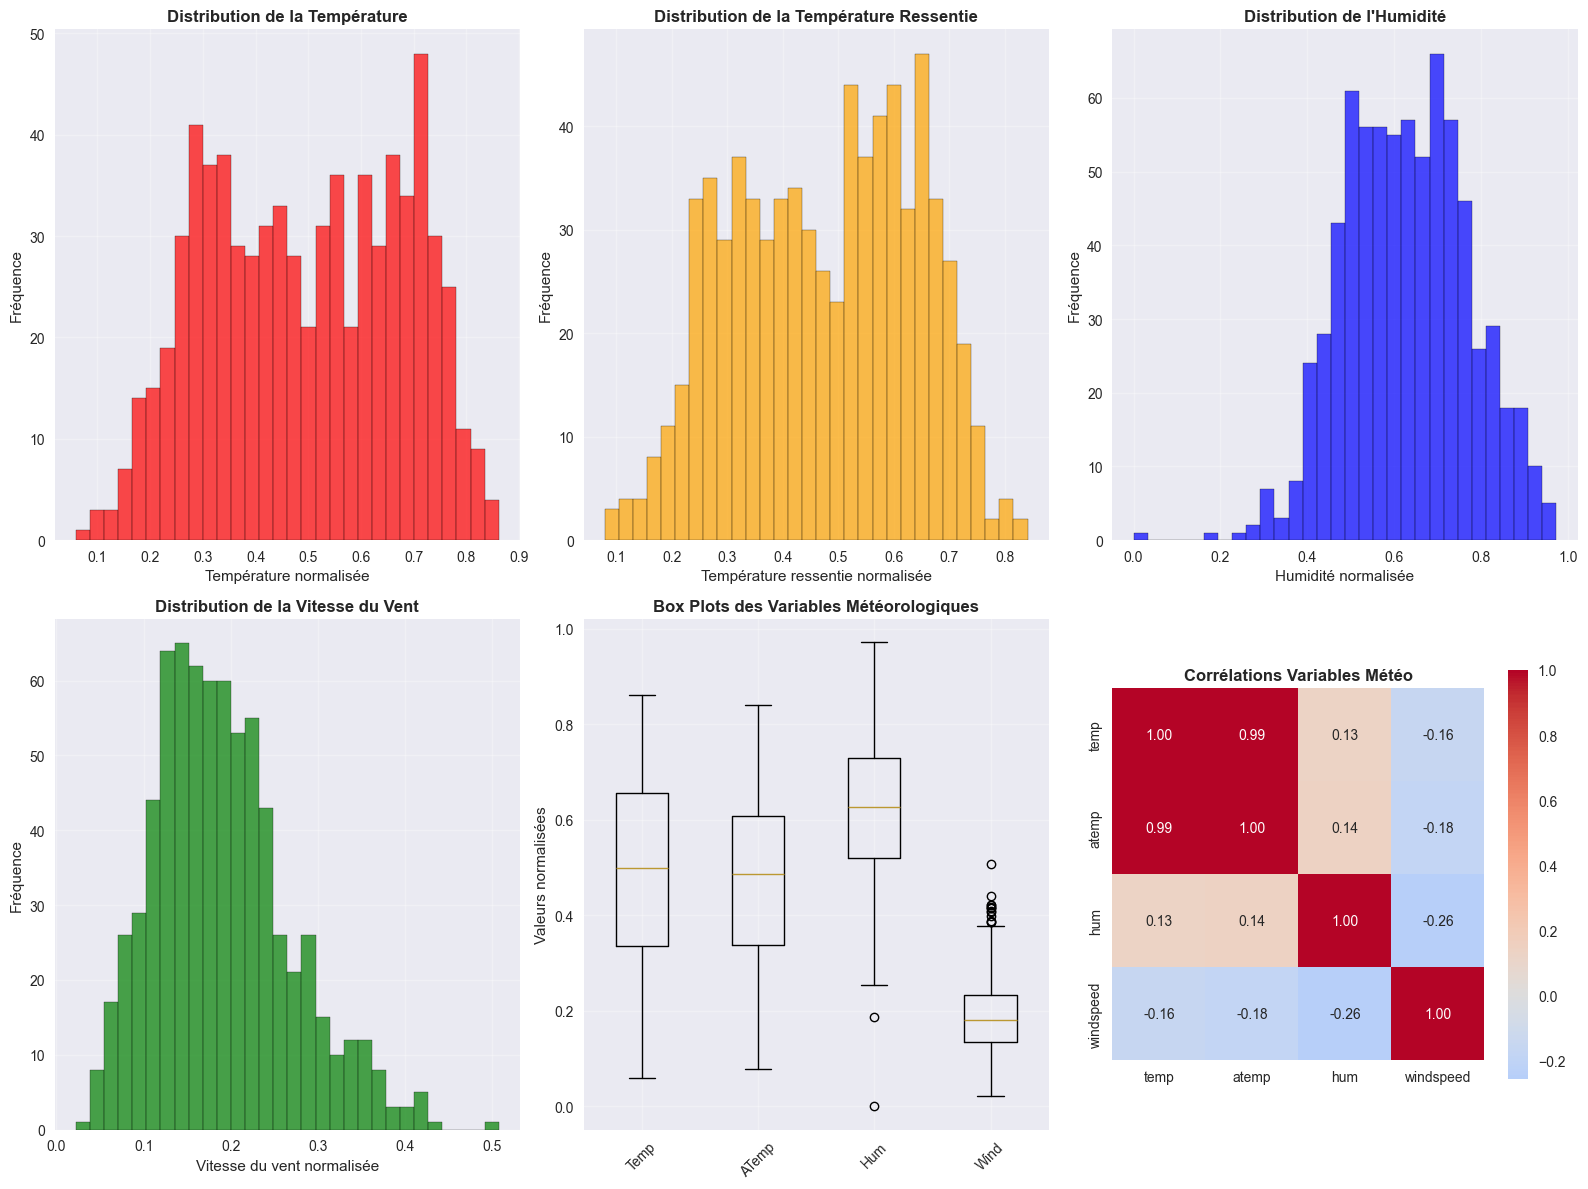

In [78]:
# Visualisations des variables numériques
plt.figure(figsize=(16, 12))

# 1. Distributions des variables météorologiques
plt.subplot(2, 3, 1)
df_day['temp'].hist(bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribution de la Température', fontsize=12, fontweight='bold')
plt.xlabel('Température normalisée')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
df_day['atemp'].hist(bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution de la Température Ressentie', fontsize=12, fontweight='bold')
plt.xlabel('Température ressentie normalisée')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
df_day['hum'].hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution de l\'Humidité', fontsize=12, fontweight='bold')
plt.xlabel('Humidité normalisée')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
df_day['windspeed'].hist(bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution de la Vitesse du Vent', fontsize=12, fontweight='bold')
plt.xlabel('Vitesse du vent normalisée')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

# 2. Box plots pour détecter les outliers
plt.subplot(2, 3, 5)
numeric_data = [df_day['temp'], df_day['atemp'], df_day['hum'], df_day['windspeed']]
plt.boxplot(numeric_data, labels=['Temp', 'ATemp', 'Hum', 'Wind'])
plt.title('Box Plots des Variables Météorologiques', fontsize=12, fontweight='bold')
plt.ylabel('Valeurs normalisées')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Matrice de corrélation des variables numériques
plt.subplot(2, 3, 6)
correlation_matrix = df_day[numeric_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Corrélations Variables Météo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 6. Analyse de la variable cible (locations)

Examinons la distribution des locations pour comprendre notre variable à prédire.


In [79]:
# Analyse de la variable cible

# Statistiques de base
print("\n Statistiques des locations:")
print(f"  Total des locations : {df_day['cnt'].sum():,}")
print(f"  Moyenne par jour : {df_day['cnt'].mean():.1f}")
print(f"  Médiane par jour : {df_day['cnt'].median():.1f}")
print(f"  Minimum : {df_day['cnt'].min()}")
print(f"  Maximum : {df_day['cnt'].max()}")
print(f"  Écart-type : {df_day['cnt'].std():.1f}")

# Répartition des locations
print("\n Répartition des locations :")
print(f"  Locations occasionnelles (casual) : {df_day['casual'].sum():,} ({df_day['casual'].sum()/df_day['cnt'].sum()*100:.1f}%)")
print(f"  Locations enregistrées (registered) : {df_day['registered'].sum():,} ({df_day['registered'].sum()/df_day['cnt'].sum()*100:.1f}%)")




 Statistiques des locations:
  Total des locations : 3,292,657
  Moyenne par jour : 4510.5
  Médiane par jour : 4548.5
  Minimum : 431
  Maximum : 8714
  Écart-type : 1931.4

 Répartition des locations :
  Locations occasionnelles (casual) : 620,015 (18.8%)
  Locations enregistrées (registered) : 2,672,642 (81.2%)


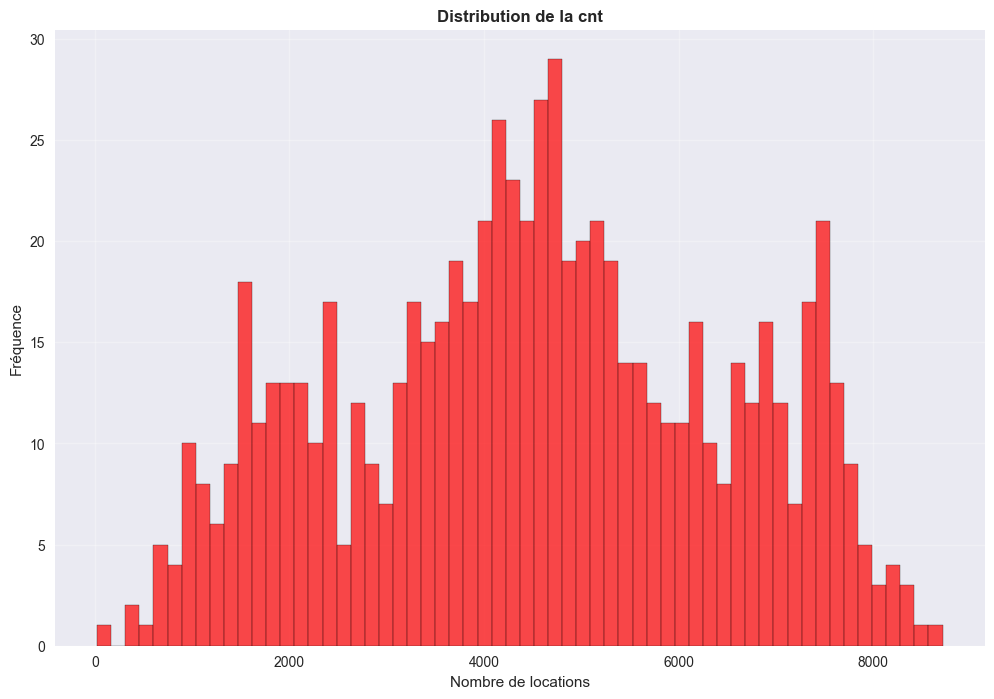

In [80]:
# Visualisations des variables numériques
plt.figure()

df_day_initial['cnt'].hist(bins=60, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribution de la cnt', fontsize=12, fontweight='bold')
plt.xlabel('Nombre de locations')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

## 7. Correlation variables et locations

### 7.1 Correlation temporel

Analysons maintenant les corrélations entre les variables temporelle et le nombre de locations.

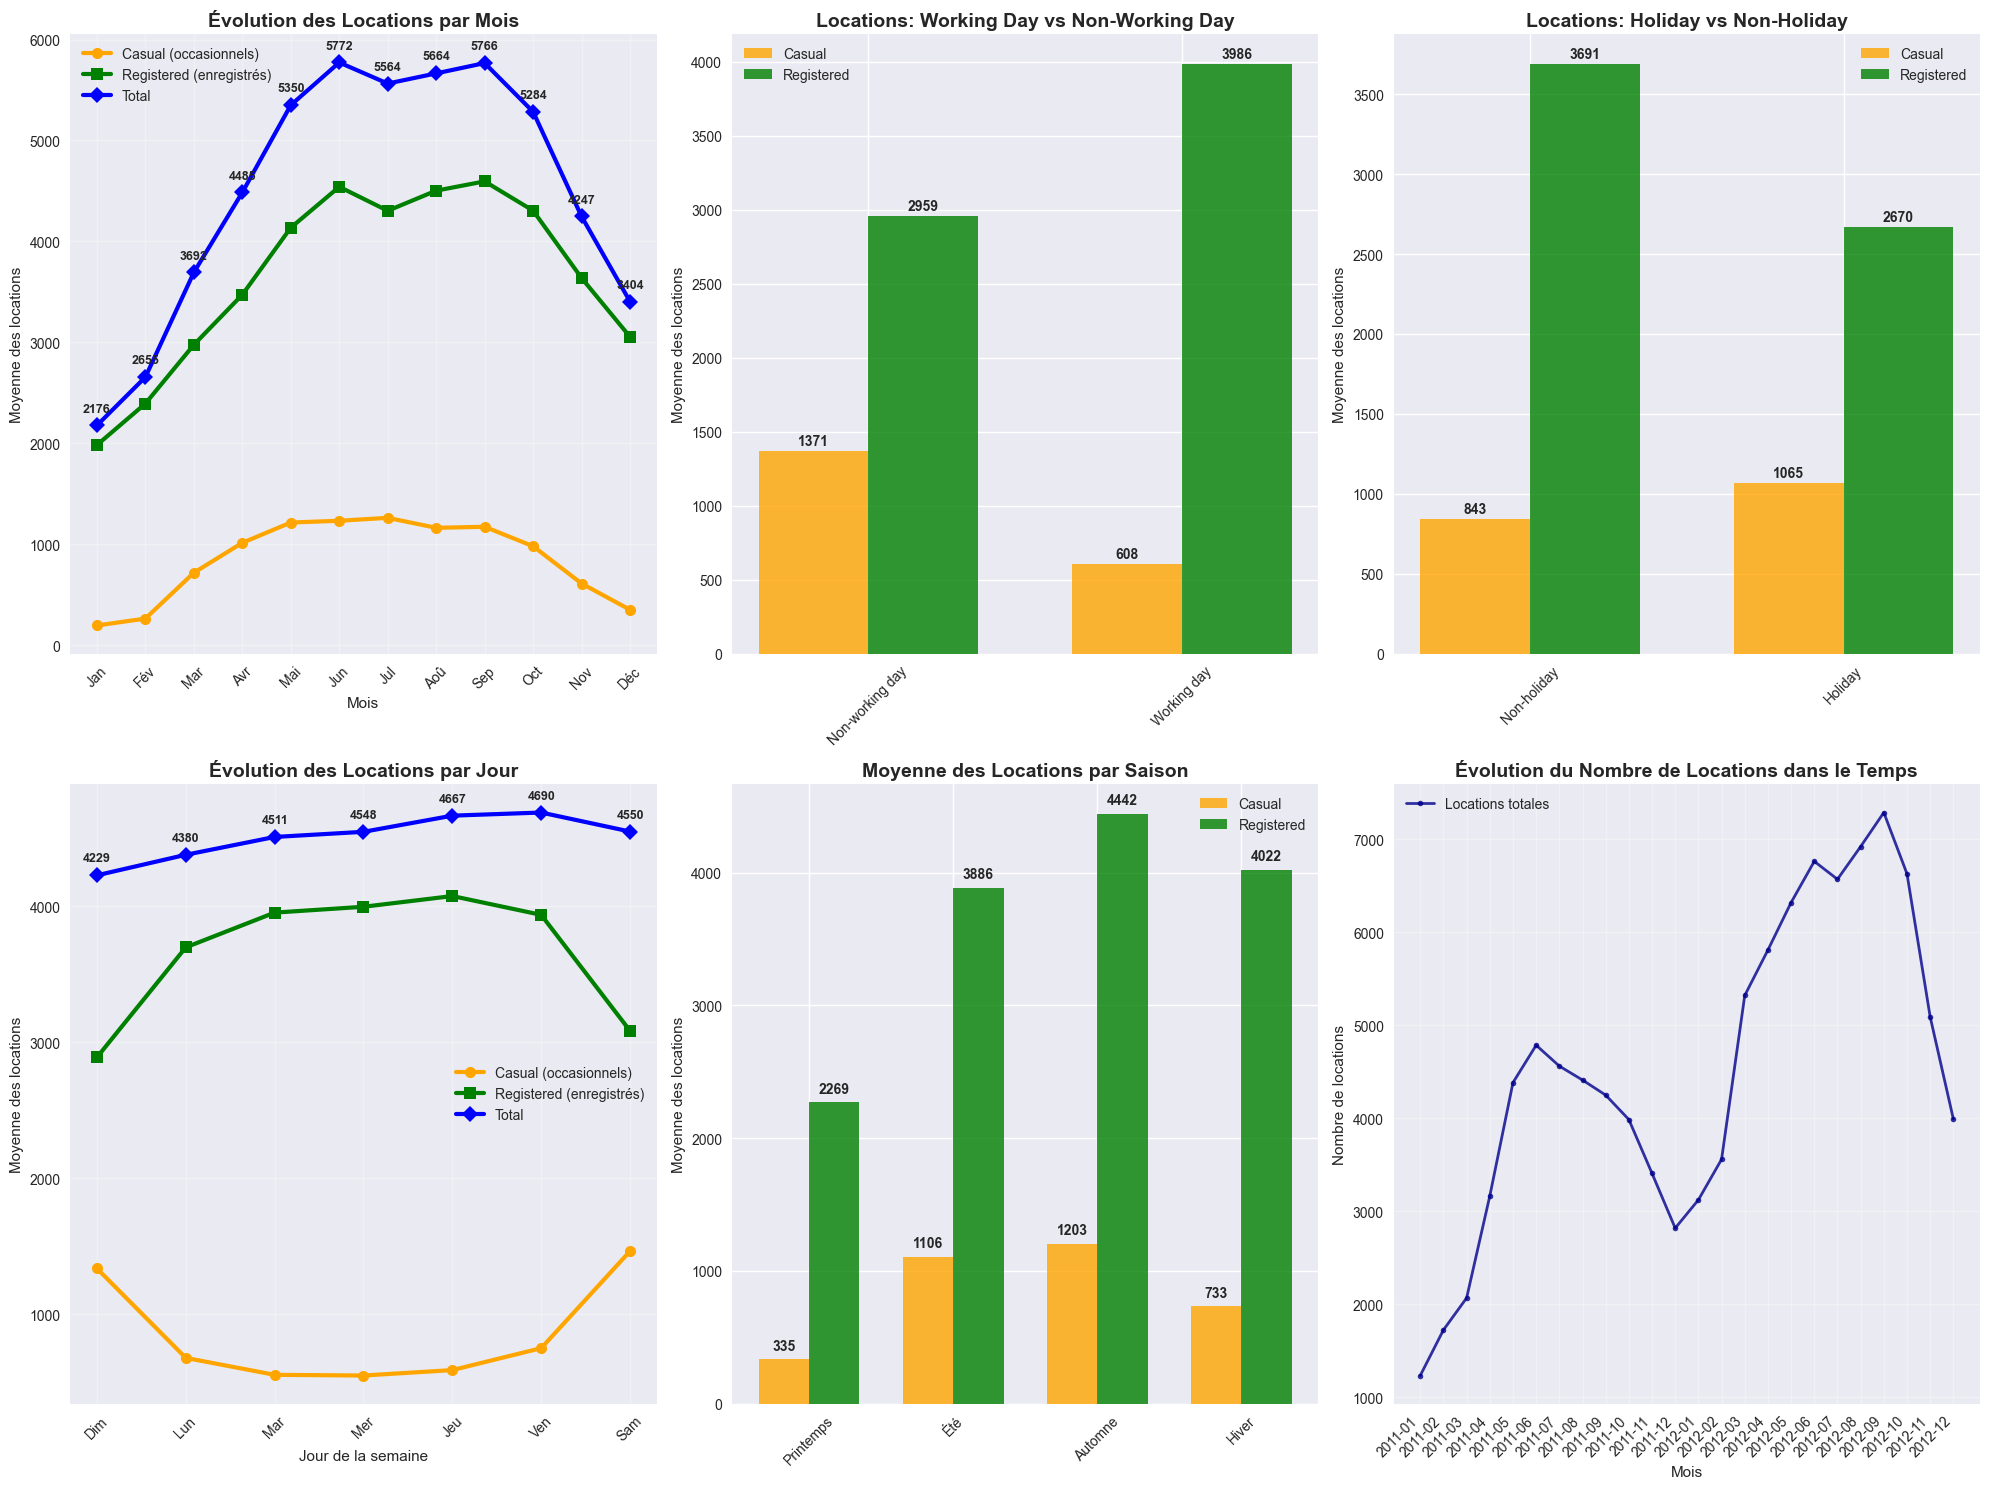


 Working day vs Non-working day :
  Working day - Casual : 607.8, Registered : 3986.2
  Non-working day - Casual : 1371.1, Registered : 2959.0
  Différence Casual : -763.4 locations (-55.7%)
  Différence Registered : +1027.1 locations (+34.7%)

 Holiday vs Non-holiday :
  Non-holiday - Casual : 843.0, Registered : 3690.5
  Holiday - Casual : 1064.7, Registered : 2670.3
  Différence Casual : +221.8 locations (+26.3%)
  Différence Registered : -1020.2 locations (-27.6%)

 Evolution mensuelle :
  Meilleur mois : Jun (5772 locations)
  Moins bon mois : Jan (2176 locations)
  Écart : 3596 locations

 Evolution annuelle :
  2011 - Casual : 677.4, Registered : 2728.4, Total : 3405.8
  2012 - Casual : 1021.3, Registered : 4593.9, Total : 5615.2


In [85]:
# Graphiques supplémentaires pour l'analyse temporelle

# Création d'une figure avec plusieurs sous-graphiques
plt.figure(figsize=(20, 15))

# 1. Évolution des locations par mois (casual, registered et total)
plt.subplot(2, 3, 1)

# Calcul des moyennes mensuelles pour chaque type
monthly_stats = df_day.groupby('mnth').agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']

# Courbes
plt.plot(range(1, 13), monthly_stats['casual'], marker='o', linewidth=3,
         markersize=8, color='orange', label='Casual (occasionnels)')
plt.plot(range(1, 13), monthly_stats['registered'], marker='s', linewidth=3,
         markersize=8, color='green', label='Registered (enregistrés)')
plt.plot(range(1, 13), monthly_stats['cnt'], marker='D', linewidth=3,
         markersize=8, color='blue', label='Total')

plt.title('Évolution des Locations par Mois', fontsize=14, fontweight='bold')
plt.xlabel('Mois')
plt.ylabel('Moyenne des locations')
plt.xticks(range(1, 13), month_names, rotation=45)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les points
for i, value in enumerate(monthly_stats['cnt']):
    plt.annotate(f'{value:.0f}', (i+1, value), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 2. Nombre moyen de locations workingday vs non-working day (casual et registered séparés)
plt.subplot(2, 3, 2)
workingday_stats = df_day.groupby('workingday').agg({
    'casual': 'mean',
    'registered': 'mean'
})

x = np.arange(2)
width = 0.35

bars1 = plt.bar(x - width/2, workingday_stats['casual'], width, label='Casual', color='orange', alpha=0.8)
bars2 = plt.bar(x + width/2, workingday_stats['registered'], width, label='Registered', color='green', alpha=0.8)

plt.title('Locations: Working Day vs Non-Working Day', fontsize=14, fontweight='bold')
plt.ylabel('Moyenne des locations')
plt.xticks(x, ['Non-working day', 'Working day'], rotation=45)
plt.legend()

# Ajouter les valeurs sur les barres
for bar, value in zip(bars1, workingday_stats['casual']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, value in zip(bars2, workingday_stats['registered']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Nombre moyen de locations holiday vs non-holiday (casual et registered séparés) 
plt.subplot(2, 3, 3) 
holiday_stats = df_day.groupby('holiday').agg({ 'casual': 'mean', 'registered': 'mean' }) 
x = np.arange(2) 
width = 0.35 
bars1 = plt.bar(x - width/2, holiday_stats['casual'], width, label='Casual', color='orange', alpha=0.8) 
bars2 = plt.bar(x + width/2, holiday_stats['registered'], width, label='Registered', color='green', alpha=0.8) 

plt.title('Locations: Holiday vs Non-Holiday', fontsize=14, fontweight='bold') 
plt.ylabel('Moyenne des locations')
plt.xticks(x, ['Non-holiday', 'Holiday'], rotation=45) 
plt.legend()

# Ajouter les valeurs sur les barres
for bar, value in zip(bars1, holiday_stats['casual']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, value in zip(bars2, holiday_stats['registered']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Évolution des locations par jour de la semaine
plt.subplot(2, 3, 4)
weekday_stats = df_day.groupby('weekday').agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

weekday_names = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']
plt.plot(weekday_names, weekday_stats['casual'], marker='o', linewidth=3, 
         markersize=8, color='orange', label='Casual (occasionnels)')
plt.plot(weekday_names, weekday_stats['registered'], marker='s', linewidth=3, 
         markersize=8, color='green', label='Registered (enregistrés)')
plt.plot(weekday_names, weekday_stats['cnt'], marker='D', linewidth=3, 
         markersize=8, color='blue', label='Total')
plt.title('Évolution des Locations par Jour', fontsize=14, fontweight='bold')
plt.xlabel('Jour de la semaine')
plt.ylabel('Moyenne des locations')
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les points
for i, value in enumerate(weekday_stats['cnt']):
    plt.annotate(f'{value:.0f}', (i, value), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 5. Comparaison saisonnière détaillée (casual et registered séparés)
plt.subplot(2, 3, 5)
season_stats = df_day.groupby('season').agg({
    'casual': 'mean',
    'registered': 'mean'
})

season_names = ['Printemps', 'Été', 'Automne', 'Hiver']
x = np.arange(len(season_names))
width = 0.35

bars1 = plt.bar(x - width/2, season_stats['casual'], width, label='Casual', color='orange', alpha=0.8)
bars2 = plt.bar(x + width/2, season_stats['registered'], width, label='Registered', color='green', alpha=0.8)

plt.title('Moyenne des Locations par Saison', fontsize=14, fontweight='bold')
plt.ylabel('Moyenne des locations')
plt.xticks(x, season_names, rotation=45)
plt.legend()

# Ajouter les valeurs sur les barres
for bar, value in zip(bars1, season_stats['casual']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, value in zip(bars2, season_stats['registered']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Évolution temporelle des locations totales (sans séparation casual/registered)
plt.subplot(2, 3, 6)

# Convertir dteday en datetime et créer une colonne mois-année
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_day['month_year'] = df_day['dteday'].dt.to_period('M')

# Grouper par mois et calculer la moyenne des locations
monthly_data = df_day.groupby('month_year')['cnt'].mean().reset_index()
monthly_data['month_year_str'] = monthly_data['month_year'].astype(str)

# Tracer le graphique avec les mois en abscisse
plt.plot(range(len(monthly_data)), monthly_data['cnt'], color='darkblue', linewidth=2, alpha=0.8, label='Locations totales', marker='o', markersize=4)
plt.title('Évolution du Nombre de Locations dans le Temps', fontsize=14, fontweight='bold')
plt.xlabel('Mois')
plt.ylabel('Nombre de locations')
plt.xticks(range(len(monthly_data)), monthly_data['month_year_str'], rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


# Working day vs Non-working day
print(f"\n Working day vs Non-working day :")
print(f"  Working day - Casual : {workingday_stats.loc[1, 'casual']:.1f}, Registered : {workingday_stats.loc[1, 'registered']:.1f}")
print(f"  Non-working day - Casual : {workingday_stats.loc[0, 'casual']:.1f}, Registered : {workingday_stats.loc[0, 'registered']:.1f}")
casual_diff = workingday_stats.loc[1, 'casual'] - workingday_stats.loc[0, 'casual']
registered_diff = workingday_stats.loc[1, 'registered'] - workingday_stats.loc[0, 'registered']
print(f"  Différence Casual : {casual_diff:+.1f} locations ({casual_diff/workingday_stats.loc[0, 'casual']*100:+.1f}%)")
print(f"  Différence Registered : {registered_diff:+.1f} locations ({registered_diff/workingday_stats.loc[0, 'registered']*100:+.1f}%)")

# Holiday vs Non-holiday
print(f"\n Holiday vs Non-holiday :")
print(f"  Non-holiday - Casual : {holiday_stats.loc[0, 'casual']:.1f}, Registered : {holiday_stats.loc[0, 'registered']:.1f}")
print(f"  Holiday - Casual : {holiday_stats.loc[1, 'casual']:.1f}, Registered : {holiday_stats.loc[1, 'registered']:.1f}")
casual_diff_holiday = holiday_stats.loc[1, 'casual'] - holiday_stats.loc[0, 'casual']
registered_diff_holiday = holiday_stats.loc[1, 'registered'] - holiday_stats.loc[0, 'registered']
print(f"  Différence Casual : {casual_diff_holiday:+.1f} locations ({casual_diff_holiday/holiday_stats.loc[0, 'casual']*100:+.1f}%)")
print(f"  Différence Registered : {registered_diff_holiday:+.1f} locations ({registered_diff_holiday/holiday_stats.loc[0, 'registered']*100:+.1f}%)")

# Évolution mensuelle
print(f"\n Evolution mensuelle :")
best_month = monthly_stats['cnt'].idxmax()
worst_month = monthly_stats['cnt'].idxmin()
print(f"  Meilleur mois : {month_names[best_month-1]} ({monthly_stats['cnt'][best_month]:.0f} locations)")
print(f"  Moins bon mois : {month_names[worst_month-1]} ({monthly_stats['cnt'][worst_month]:.0f} locations)")
print(f"  Écart : {monthly_stats['cnt'][best_month] - monthly_stats['cnt'][worst_month]:.0f} locations")

# Évolution annuelle : 2011 vs 2012
print(f"\n Evolution annuelle :")
year_stats = df_day.groupby('yr').agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

print(f"  2011 - Casual : {year_stats.loc[0, 'casual']:.1f}, Registered : {year_stats.loc[0, 'registered']:.1f}, Total : {year_stats.loc[0, 'cnt']:.1f}")
print(f"  2012 - Casual : {year_stats.loc[1, 'casual']:.1f}, Registered : {year_stats.loc[1, 'registered']:.1f}, Total : {year_stats.loc[1, 'cnt']:.1f}")

In [82]:
# Résumé des corrélations temporelles
print("Résumé des corrélations temporelles :")
temporal_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
print("Variable temporelle | Casual | Registered | Total")
for var in temporal_vars:
    corr_casual = df_day[var].corr(df_day['casual'])
    corr_registered = df_day[var].corr(df_day['registered'])
    corr_total = df_day[var].corr(df_day['cnt'])
    print(f"{var:18s} | {corr_casual:6.3f} | {corr_registered:10.3f} | {corr_total:5.3f}")



Résumé des corrélations temporelles :
Variable temporelle | Casual | Registered | Total
season             |  0.213 |      0.418 | 0.412
yr                 |  0.251 |      0.600 | 0.572
mnth               |  0.125 |      0.298 | 0.284
holiday            |  0.054 |     -0.110 | -0.069
weekday            |  0.058 |      0.054 | 0.065
workingday         | -0.518 |      0.307 | 0.064


### 7.2 Correlation météo

Analysons maintenant les corrélations entre les variables météorologiques et le nombre de locations, en séparant les utilisateurs Casual et Registered pour voir les différences de comportement.

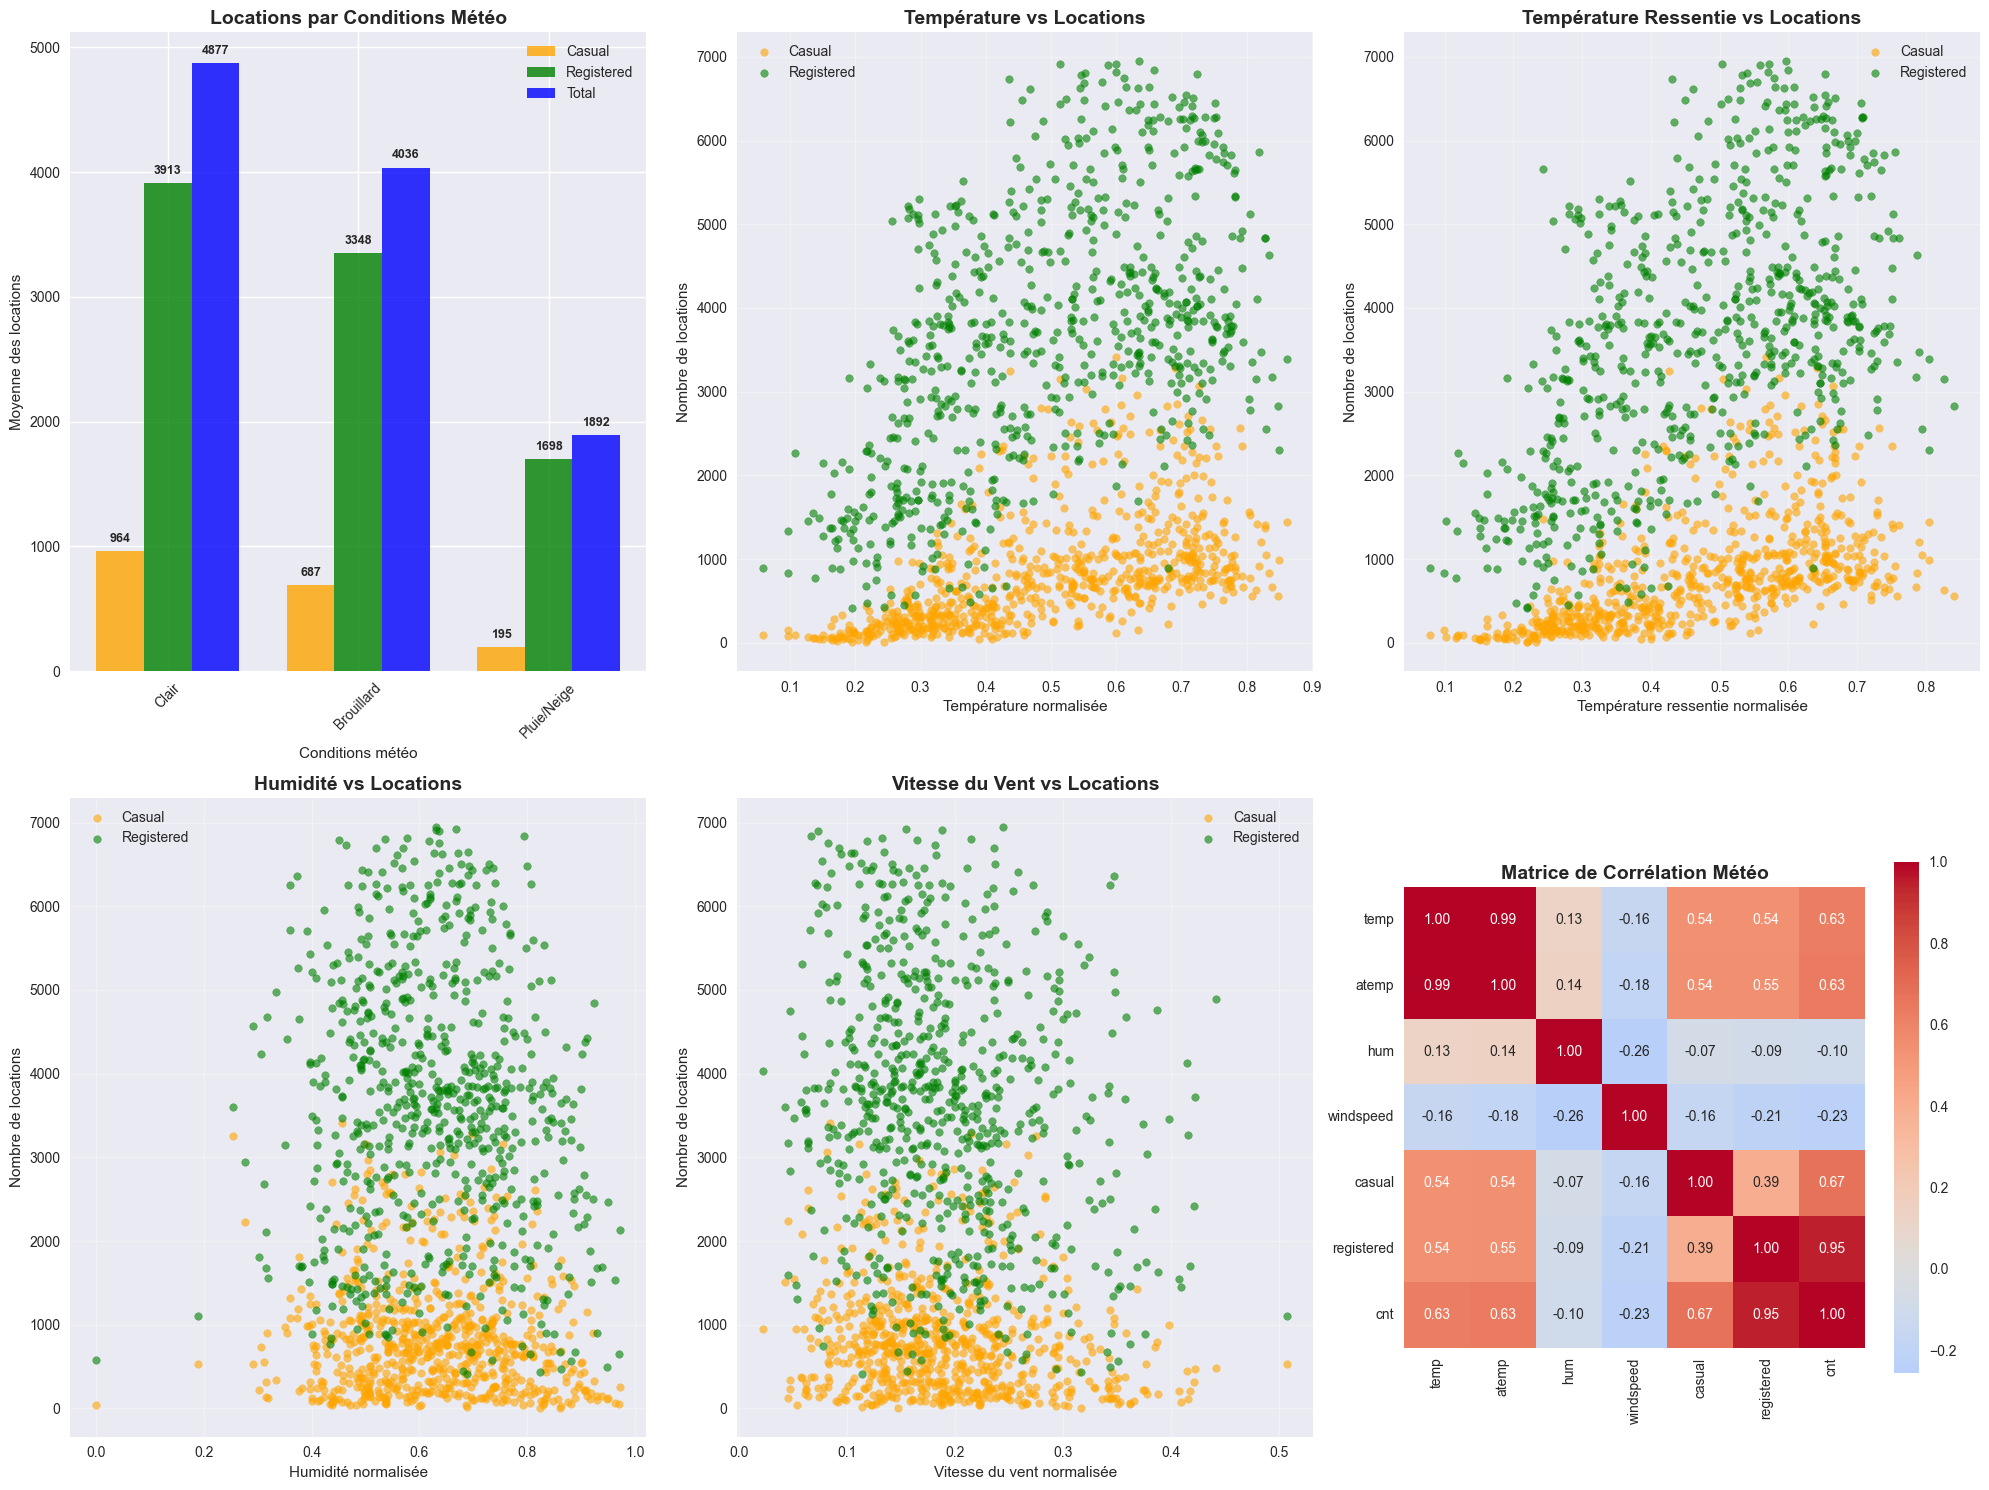

In [83]:
# Graphiques de corrélation météo avec les locations

# Création d'une figure avec plusieurs sous-graphiques
plt.figure(figsize=(20, 15))

# 1. Corrélation par conditions météo (weathersit) - Casual vs Registered
plt.subplot(2, 3, 1)
weather_stats = df_day.groupby('weathersit').agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

weather_names = ['Clair', 'Brouillard', 'Pluie/Neige']
x = np.arange(len(weather_names))
width = 0.25

bars1 = plt.bar(x - width, weather_stats['casual'], width, label='Casual', color='orange', alpha=0.8)
bars2 = plt.bar(x, weather_stats['registered'], width, label='Registered', color='green', alpha=0.8)
bars3 = plt.bar(x + width, weather_stats['cnt'], width, label='Total', color='blue', alpha=0.8)

plt.title('Locations par Conditions Météo', fontsize=14, fontweight='bold')
plt.ylabel('Moyenne des locations')
plt.xlabel('Conditions météo')
plt.xticks(x, weather_names, rotation=45)
plt.legend()

# Ajouter les valeurs sur les barres
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    # Valeurs pour chaque barre
    value1 = weather_stats.iloc[i, 0]  # casual
    value2 = weather_stats.iloc[i, 1]  # registered  
    value3 = weather_stats.iloc[i, 2]  # cnt
    
    # Annotations
    plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 50, 
             f'{value1:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 50, 
             f'{value2:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.text(bar3.get_x() + bar3.get_width()/2, bar3.get_height() + 50, 
             f'{value3:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Scatter plot - Température vs Locations (Casual et Registered séparés)
plt.subplot(2, 3, 2)
plt.scatter(df_day['temp'], df_day['casual'], alpha=0.6, color='orange', s=30, label='Casual')
plt.scatter(df_day['temp'], df_day['registered'], alpha=0.6, color='green', s=30, label='Registered')


plt.title('Température vs Locations', fontsize=14, fontweight='bold')
plt.xlabel('Température normalisée')
plt.ylabel('Nombre de locations')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Scatter plot - Température ressentie vs Locations
plt.subplot(2, 3, 3)
plt.scatter(df_day['atemp'], df_day['casual'], alpha=0.6, color='orange', s=30, label='Casual')
plt.scatter(df_day['atemp'], df_day['registered'], alpha=0.6, color='green', s=30, label='Registered')

plt.title('Température Ressentie vs Locations', fontsize=14, fontweight='bold')
plt.xlabel('Température ressentie normalisée')
plt.ylabel('Nombre de locations')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Scatter plot - Humidité vs Locations
plt.subplot(2, 3, 4)
plt.scatter(df_day['hum'], df_day['casual'], alpha=0.6, color='orange', s=30, label='Casual')
plt.scatter(df_day['hum'], df_day['registered'], alpha=0.6, color='green', s=30, label='Registered')

plt.title('Humidité vs Locations', fontsize=14, fontweight='bold')
plt.xlabel('Humidité normalisée')
plt.ylabel('Nombre de locations')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Scatter plot - Vitesse du vent vs Locations
plt.subplot(2, 3, 5)
plt.scatter(df_day['windspeed'], df_day['casual'], alpha=0.6, color='orange', s=30, label='Casual')
plt.scatter(df_day['windspeed'], df_day['registered'], alpha=0.6, color='green', s=30, label='Registered')

plt.title('Vitesse du Vent vs Locations', fontsize=14, fontweight='bold')
plt.xlabel('Vitesse du vent normalisée')
plt.ylabel('Nombre de locations')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Matrice de corrélation météo
plt.subplot(2, 3, 6)
weather_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
correlation_matrix = df_day[weather_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Matrice de Corrélation Météo', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [84]:
# Analyse détaillée des corrélations météo

# Calcul des corrélations pour chaque type d'utilisateur
weather_vars = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit']
target_vars = ['casual', 'registered', 'cnt']

print("\n1. Corrélations par type d'utilisateur :")
for target in target_vars:
    correlations = []
    for weather_var in weather_vars:
        corr = df_day[weather_var].corr(df_day[target])
        correlations.append(f"{weather_var}: {corr:6.3f}")
    print(f"{target.upper():12s} : {', '.join(correlations)}")

# Analyse par conditions météo
print("\n2. Analyse par conditions météo")
weather_analysis = df_day.groupby('weathersit').agg({
    'casual': ['mean', 'std'],
    'registered': ['mean', 'std'],
    'cnt': ['mean', 'std']
}).round(1)

weather_names = {1: 'Clair', 2: 'Brouillard', 3: 'Pluie/Neige'}
for weather, name in weather_names.items():
    casual_mean = weather_analysis.loc[weather, ('casual', 'mean')]
    casual_std = weather_analysis.loc[weather, ('casual', 'std')]
    registered_mean = weather_analysis.loc[weather, ('registered', 'mean')]
    registered_std = weather_analysis.loc[weather, ('registered', 'std')]
    total_mean = weather_analysis.loc[weather, ('cnt', 'mean')]
    total_std = weather_analysis.loc[weather, ('cnt', 'std')]
    
    print(f"{name} ({weather}) : Casual {casual_mean:.0f}±{casual_std:.0f}, Registered {registered_mean:.0f}±{registered_std:.0f}, Total {total_mean:.0f}±{total_std:.0f}")


# Impact des conditions météo
print("\n3. Impact des conditions météo :")
clear_weather = weather_analysis.loc[1]
bad_weather = weather_analysis.loc[3]

print("Comparaison Clair vs Pluie/Neige :")
for target in ['casual', 'registered', 'cnt']:
    clear_mean = clear_weather[(target, 'mean')]
    bad_mean = bad_weather[(target, 'mean')]
    diff = clear_mean - bad_mean
    pct_diff = (diff / bad_mean) * 100
    print(f"  {target:12s} : {diff:+.0f} locations ({pct_diff:+.1f}%)")

# Analyse des températures
print("\n4. Analyse des températures : ")
temp_quartiles = df_day['temp'].quantile([0.25, 0.5, 0.75])
print(f"Température - Q1: {temp_quartiles[0.25]:.3f}, Médiane: {temp_quartiles[0.5]:.3f}, Q3: {temp_quartiles[0.75]:.3f}")

# Locations par quartiles de température
temp_bins = pd.cut(df_day['temp'], bins=[0, temp_quartiles[0.25], temp_quartiles[0.5], temp_quartiles[0.75], 1], 
                   labels=['Très froid', 'Froid', 'Chaud', 'Très chaud'])
temp_analysis = df_day.groupby(temp_bins).agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

print("\nLocations par température :")
for temp_range, stats in temp_analysis.iterrows():
    print(f"  {temp_range:12s} : Casual {stats['casual']:6.0f}, Registered {stats['registered']:6.0f}, Total {stats['cnt']:6.0f}")

# Analyse de l'humidité
print("\n5. Analyse de l'humidité :")
hum_quartiles = df_day['hum'].quantile([0.25, 0.5, 0.75])
print(f"Humidité - Q1: {hum_quartiles[0.25]:.3f}, Médiane: {hum_quartiles[0.5]:.3f}, Q3: {hum_quartiles[0.75]:.3f}")

# Locations par quartiles d'humidité
hum_bins = pd.cut(df_day['hum'], bins=[0, hum_quartiles[0.25], hum_quartiles[0.5], hum_quartiles[0.75], 1], 
                  labels=['Très sec', 'Sec', 'Humide', 'Très humide'])
hum_analysis = df_day.groupby(hum_bins).agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

print("\nLocations par humidité :")
for hum_range, stats in hum_analysis.iterrows():
    print(f"  {hum_range:12s} : Casual {stats['casual']:6.0f}, Registered {stats['registered']:6.0f}, Total {stats['cnt']:6.0f}")

# Analyse de la vitesse du vent
print("\n6. Analyse de la vitesse du vent :")
wind_quartiles = df_day['windspeed'].quantile([0.25, 0.5, 0.75])
print(f"Vitesse du vent - Q1: {wind_quartiles[0.25]:.3f}, Médiane: {wind_quartiles[0.5]:.3f}, Q3: {wind_quartiles[0.75]:.3f}")

# Locations par quartiles de vitesse du vent
wind_bins = pd.cut(df_day['windspeed'], bins=[0, wind_quartiles[0.25], wind_quartiles[0.5], wind_quartiles[0.75], 1], 
                   labels=['Très calme', 'Calme', 'Venteux', 'Très venteux'])
wind_analysis = df_day.groupby(wind_bins).agg({
    'casual': 'mean',
    'registered': 'mean',
    'cnt': 'mean'
}).round(1)

print("\nLocations par vitesse du vent :")
for wind_range, stats in wind_analysis.iterrows():
    print(f"  {wind_range:12s} : Casual {stats['casual']:6.0f}, Registered {stats['registered']:6.0f}, Total {stats['cnt']:6.0f}")

print("\n" + "=" * 80)



1. Corrélations par type d'utilisateur :
CASUAL       : temp:  0.543, atemp:  0.544, hum: -0.074, windspeed: -0.165, weathersit: -0.244
REGISTERED   : temp:  0.541, atemp:  0.546, hum: -0.086, windspeed: -0.212, weathersit: -0.253
CNT          : temp:  0.629, atemp:  0.633, hum: -0.096, windspeed: -0.229, weathersit: -0.291

2. Analyse par conditions météo
Clair (1) : Casual 964±700, Registered 3913±1533, Total 4877±1880
Brouillard (2) : Casual 687±619, Registered 3348±1464, Total 4036±1809
Pluie/Neige (3) : Casual 195±264, Registered 1698±1030, Total 1892±1202

3. Impact des conditions météo :
Comparaison Clair vs Pluie/Neige :
  casual       : +769 locations (+395.4%)
  registered   : +2215 locations (+130.5%)
  cnt          : +2984 locations (+157.7%)

4. Analyse des températures : 
Température - Q1: 0.337, Médiane: 0.499, Q3: 0.656

Locations par température :
  Très froid   : Casual    283, Registered   2332, Total   2615
  Froid        : Casual    725, Registered   3484, Total  


## Conclusion


On observe une différence majeure entre Casual et Registered dans le comportement temporel: Casual préfère weekends, Registered préfère working days

Néanmoins, concernant la sensibilité à la météo, le résultat est similaire entre les deux groupes

De plus temp et atemps sont très corrélé, il n'est pas nécessaire de garder les deux 

**Recommandation**
La séparation des utilisateurs Casual et Registered dans la modélisation prédictive peut être interessant. De plus, il serai redondant de considérer temp et atemp
